In [18]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
import testcases
from importlib import reload


In [19]:
def myLog(x):
    logx = np.log(np.maximum(1e-20,x))
    # logx = np.log(x)
    if np.isnan(logx).any() == True:
        print(f'Inside myLog: NaN encountered!\nmin_x:{x.min()}')
        return None
    else:
        return logx

def x2Y(x):
    Y = x[0:2*M].reshape(-1,2)
    return Y

def x2P(x):
    P = x[2*M:].reshape(-1,M)
    return P

def YP2x(Y, P):
    y = Y.flatten()
    p = P.flatten()
    x = np.concatenate((y,p))
    return x

# Auxiliary functions to project back into the feasible space
def project_to_stochastic_matrix(matrix):
    """
    Projects each row of the input matrix onto the simplex (triangle) defined by:
    - The row sums to 1
    - Each element in the row lies within [0, 1]

    :param matrix: np.ndarray, the input matrix (shape: NxM)
    :return: np.ndarray, the projected matrix (same shape as input)
    """
    def project_to_plane(vector):
        N = vector.shape[0]
        normal = np.ones((N,))
        p = 1 / N * np.ones((N,))
        n_dot_n = N
        v_dot_n = np.dot(vector, normal)
        p_dot_n = np.dot(p, normal)
        projection = vector - ((v_dot_n - p_dot_n) / n_dot_n) * normal
        return projection

    def project_to_triangle(v):
        tol = 1e-7
        v_proj = project_to_plane(v)
        v_clamped = np.clip(v_proj, tol, 1 - tol)
        sum_clamped = np.sum(v_clamped)

        if sum_clamped == 1:
            return v_clamped
        elif sum_clamped < 1:
            deficit = 1 - sum_clamped
            free_indices = v_clamped < 1
            num_free = np.sum(free_indices)
            if num_free > 0:
                increment = deficit / num_free
                v_clamped[free_indices] += increment
            return v_clamped
        else:
            return v_clamped / sum_clamped

    # Apply the projection to each row of the matrix
    projected_matrix = np.apply_along_axis(project_to_triangle, axis=1, arr=matrix)
    return projected_matrix

In [20]:
# create FLP class and its associated functions
class FLP():
    # declare the class variables
    N : int # number of resources
    M : int # number of facilities
    d : int # dimension of the problem
    resLoc : np.ndarray # resource locations
    rho : np.ndarray # rosource weights
    C : np.ndarray # capacity constraints
    
    # initialize the class variables
    def __init__(self, N, M, d, resLoc, rho, C, P_eps, beta_tol):
        self.N = N
        self.M = M
        self.d = d
        self.resLoc = resLoc
        self.rho = rho
        self.C = C
        self.P_eps = P_eps
        self.beta_tol = beta_tol
        print('================= Class FLP() initialized =================')

    # function to plot FLP results
    def plot_flp(self, res_means, facLoc0):
        ''' 
        input - flp : the class instance
                N : # resources
                M : # facilities
                resLoc : resource locations
                facLoc0 : initial facility locations
                facLoc_opt : final facility locations (supposedly optimal)
                ineq_figures : data for plotting inequality constraints, datatype is variable
        output: None
        '''
        N = self.N
        M = self.M
        resLoc = self.resLoc
        # initialize figure
        figure, axes = plt.subplots()
        # resources locations
        plt.scatter(resLoc[:, 0], resLoc[:, 1], marker = "o", color = 'blue', alpha=0.3)
        # resource means
        plt.scatter(res_means[:, 0], res_means[:, 1], marker = ".", color = 'red')
        # initial facility locations
        plt.scatter(facLoc0[:, 0], facLoc0[:, 1], marker = "D", color = 'green')
        # final facility locations
        # plt.scatter(facLoc_opt[:, 0], facLoc_opt[:, 1], marker = "+", color = 'black')
        plt.title('Facility and resource locations - N = ' + str(N) + ', M = ' + str(M))
        # plt.legend(['resources', 'cluster means', 'initial facilities', 'optimal facilities'])

        plt.grid()
        plt.show()
        return None

    def h_hdot(self, P_ylx, u_p):
        h = P_ylx * (1 - P_ylx)
        hdot = cp.multiply((1 - 2 * P_ylx), u_p)
        return h, hdot

    def l_ldot(self, P_ylx, u_p):
        c = self.C
        q = self.rho.flatten()
        l = c - np.dot(q, P_ylx)
        ldot = - (q[:,np.newaxis].T @ u_p).flatten()
        return l, ldot

    def F_Fdot_clustering(self, Y, P_ylx, u_y, u_p, u_b, beta):
        # Computation of the free energy
        N = self.N
        m = self.M
        X = self.resLoc
        q = self.rho.flatten()
        D = cdist(X,Y,metric='sqeuclidean')
        Px = np.diag(q)
        Py = np.sum(Px @ P_ylx, axis = 0)
        F = np.sum(Px @ np.multiply(P_ylx, D + 1/beta * np.log(P_ylx)))
        F_shifted = F + 1/beta * np.log(m)

        # Time derivatives
        ## w.r.t Y: sum_{j=1}^m (dF/dy_j)^T u_j
        dFdY = 2 * (Py[:, np.newaxis] * Y - P_ylx.T @ Px @ X)
        dotF_y = cp.sum(cp.multiply(dFdY,u_y))

        ## w.r.t P_{y|x}: \sum_{i,j} dF/dp_{j|i} v_ij
        dotF_p = cp.sum(cp.multiply(Px @ (D + 1/beta * np.log(P_ylx) + 1/beta), u_p))

        ## w.r.t beta: (1/beta)^2 H
        dFdb = -1/beta**2 * np.sum(Px @ np.multiply(P_ylx, np.log(P_ylx)))
        dotF_beta = dFdb * u_b

        # Total time derivative
        Fdot = dotF_y + dotF_p + dotF_beta

        return F_shifted, Fdot

    def control_dyn(self, x, beta, u_b, p, gamma, alpha_h, alpha_l):
        N = flp.N
        m = flp.M
        q = self.rho.flatten()
        c = self.C
        Y = x2Y(x)
        P_ylx = x2P(x)
        # Decision variables 
        u_p = cp.Variable((N,m))
        u_y = cp.Variable((m,2))  
        delta = cp.Variable(1)

        # Objective: minimize the sum of squares of x and the sum of q
        objective = cp.Minimize(cp.sum_squares(u_p) + cp.sum_squares(u_y) + p * delta**2)

        # Define constraints
        F , Fdot = self.F_Fdot_clustering(Y, P_ylx, u_y, u_p, u_b, beta)
        h, h_dot = self.h_hdot(P_ylx, u_p)
        l, l_dot = self.l_ldot(P_ylx, u_p)

        constraints = [
            Fdot <= -gamma * F + delta,
            cp.sum(u_p, axis=1) == 0,
            h_dot >= -alpha_h * h,
            l_dot >= -alpha_l * l
        ]

        # Define the problem
        problem = cp.Problem(objective, constraints)

        # Solver Options for OSQP
        solver_options = {
            'max_iter': 50000,         # Increase max iterations to 20000
            'eps_abs': 1e-4,           # Adjust absolute tolerance
            'eps_rel': 1e-4,           # Adjust relative tolerance
            'eps_prim_inf': 1e-3,      # Adjust primal infeasibility tolerance
            'eps_dual_inf': 1e-3,      # Adjust dual infeasibility tolerance
            'verbose': False           # Enable verbose output to track solver progress
        }

        # Solve the problem using OSQP with customized options
        result = problem.solve(solver = 'OSQP', **solver_options)
        
        # Check the results
        if np.isnan(problem.value).any() == True:
            print("Nan encountered!")
            return np.zeros((N,m)), np.zeros((m,2)), F, 0
        else:         
            return u_p.value, u_y.value, F, Fdot.value
    
    def dynamics(self, x, beta, p, gamma, alpha_h, alpha_l):    
        # Unpack the state vector
        Y = x2Y(x)
        P = x2P(x)
        u_b = 0
        # Compute control inputs; control_dyn should return u_p and u_y for state evolution.
        u_p, u_y, F_b, Fdot_b = self.control_dyn(x, beta, u_b, p, gamma, alpha_h, alpha_l) 
        # Flatten the derivatives into a single vector
        dxdt = YP2x(u_y, u_p)
        return dxdt, F_b, Fdot_b

    def optimize_CBF_CLF(self, x0, beta, p, gamma, alpha_h, alpha_l, T_f, dt_init=0.01, dt_min=1e-4, dt_max=0.1, Ftol=1e-2, xtol=1e-2, allowPrint=False):
        # initialization
        x_prev = x0
        dt_prev = dt_init 
        theta_prev = np.inf 
        t = 0.0
        iter_count = 0

        while t < T_f:
            # Compute gradient step
            dxdt, F, Fdot = self.dynamics(x_prev, beta, p, gamma, alpha_h, alpha_l)

            # Compute new step size (lambda_k)
            if iter_count > 0:
                step_size_1 = np.sqrt(1 + theta_prev) * dt_prev
                grad_diff = np.linalg.norm(dxdt - dxdt_old) + 1e-6  # Regularization term to prevent division by zero
                step_size_2 = np.linalg.norm(x_prev - x_old) / (2 * grad_diff)  
                dt = min(max(step_size_2, dt_min), dt_max)  # Keep dt in range [dt_min, dt_max]
            else:
                dt = dt_init  # First iteration uses initial step size

            # Euler update
            x_next = x_prev + dt * dxdt

            # Projection step for P
            x_projected = YP2x(
                x2Y(x_next), 
                project_to_stochastic_matrix(x2P(x_next)))

            # Compute new theta_k
            if iter_count > 0:
                theta = dt / dt_prev
            else:
                theta = 1.0  # Initial theta value

            # Update variables for next iteration
            x_old = x_prev
            dxdt_old = dxdt
            dt_prev = dt
            theta_prev = theta
            x_prev = x_projected
            t += dt
            iter_count += 1

            # Termination condition if |Fdot| is too small
            if abs(Fdot*dt) < Ftol:
                print(f"Ftol successful\titer:{iter_count}\ttime {t:.3e}\tFtol={abs(Fdot*dt):.3e} < Ftol={Ftol:.3e}")
                break
            elif max(abs(dxdt)*dt) < xtol:
                print(f"xtol successful\titer:{iter_count}\ttime {t:.3e}\txtol={max(abs(dxdt*dt)):.3e} < xtol={xtol:.3e}")
                break
            elif allowPrint:
                print(f't{t:.3e}\tF:{F:.6f}\tFdot:{Fdot:6f}\tdt:{dt:.5f}\tdxdt_norm:{np.max(np.abs(dxdt)):.6f}\tdx:{np.max(np.abs(dxdt))*dt:.6f}')

        return x_prev, F

    # function to perform deterministic annealing
    def anneal(self, x0, beta0, betaf, beta_grow, p, gamma, alpha_h, alpha_l, T_f=15, dt_init=0.01, dt_min=1e-4, dt_max=0.1, Ftol=1e-2, xtol=1e-2, allowPrint=False):
        xb = x0
        beta = beta0
        F_array = []
        b_array = []
        P_array = np.array([x2P(x0)])
        Y_array = np.array([x2Y(x0)])
        
        while beta <= betaf:
            
            xb, Fb = self.optimize_CBF_CLF(xb, beta, p, gamma, alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, Ftol, xtol)
            xb[:2*self.M] += np.random.multivariate_normal(np.zeros(2*self.M), 0.001*np.eye(2*self.M))
            beta *= beta_grow
        
            # store data
            F_array.append(Fb)
            b_array.append(beta)
            P_array = np.concatenate((P_array, np.array([x2P(xb)])), axis=0)
            Y_array = np.concatenate((Y_array, np.array([x2Y(xb)])), axis=0)

            if allowPrint:
                print(f'beta:{beta:.3e}\tF:{Fb:.3e}')

        return F_array, b_array, P_array, Y_array


### Initialize an FLP problem, and test all the functions

================= Class FLP() initialized =================


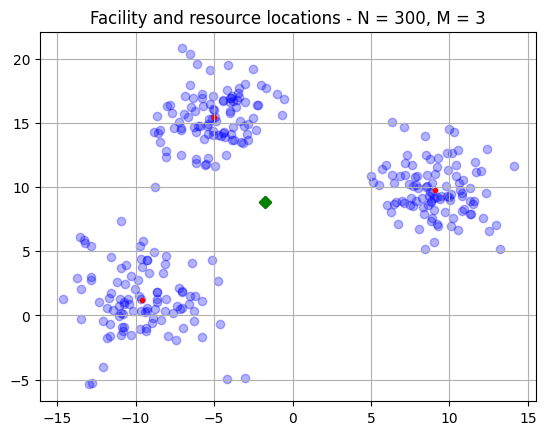

rho shape: (300, 1)
cluster split: [0.33 0.33 0.34]
capacity limit: [0.33334333 0.33334333 0.33334333]

centroid:[-1.73115456  8.7971303 ]


In [21]:
reload(testcases)
# load a testcase
N, M, d, resLoc, Y0, res_means, split_pct, rho = testcases.testcases('small_tc_300_3')
# C = np.random.uniform(0,1,len(split_pct))
C = np.ones(shape=split_pct.shape)
C = C/np.sum(C) + 1e-5

# initialize FLP class
flp = FLP(N, M, d, resLoc, rho, C, P_eps=1e-8, beta_tol=1e-10)
flp.plot_flp(res_means, Y0)
print(f'rho shape: {rho.shape}')
print(f'cluster split: {split_pct}')
print(f'capacity limit: {C}\n')
centroid = np.sum(rho*resLoc, axis=0)
print(f'centroid:{centroid}')

In [22]:
# initial state
# P0 = np.ones(shape=(flp.N, flp.M))
P0 = np.random.uniform(0,1,(flp.N, flp.M)) + flp.P_eps
P0 = P0/P0.sum(axis=1,keepdims=True)
x0 = YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

# Setting the coefficients
alpha_h = 20
alpha_l = 20
p = 1
gamma = 20
u_b = 0.0

# test functions
beta0 = 1e-1; print(f'beta\tvalue:{beta0:.2e}')
u_p, u_y, F, Fdot = flp.control_dyn(x0, beta0, u_b, p, gamma, alpha_h, alpha_l)
print(f'u_p\tshape:{u_p.shape}\tnorm:{np.max(np.abs(u_p))}')
print(f'u_y\tshape:{u_y.shape}\tnorm:{np.max(np.abs(u_y))}')
print(f'F\tvalue:{F:.3e}')
print(f'Fdot\tvalue:{Fdot:.3e}')

x0	shape:(906,)
beta	value:1.00e-01
u_p	shape:(300, 3)	norm:165.0507544946596
u_y	shape:(3, 2)	norm:364.13720498955064
F	value:1.085e+02
Fdot	value:-1.027e+03


/Users/dhananjaytiwari/Library/Python/3.9/lib/python/site-packages/cvxpy/expressions/expression.py:497: FutureWarning: 
    You didn't specify the order of the flatten expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(flatten_order_warning, FutureWarning)


In [24]:
x1, F1 = flp.optimize_CBF_CLF(x0, beta0, p, gamma, alpha_h, alpha_l, T_f=4, dt_init=0.5, dt_min=1e-5, dt_max=1, Ftol=1e-3, xtol=1e-3, allowPrint=True)

t5.000e-01	F:108.468722	Fdot:-1027.468700	dt:0.50000	dxdt_norm:364.137205	dx:182.068602
t5.498e-01	F:18269.602226	Fdot:-365385.349180	dt:0.04980	dxdt_norm:826.935134	dx:41.179604
t5.719e-01	F:12313.904845	Fdot:-246289.411622	dt:0.02207	dxdt_norm:1146.006113	dx:25.295603
t6.328e-01	F:7772.900642	Fdot:-155440.709174	dt:0.06089	dxdt_norm:1062.164001	dx:64.670857
t6.908e-01	F:1750.895044	Fdot:-35002.335469	dt:0.05803	dxdt_norm:459.389495	dx:26.656258
t7.428e-01	F:329.378626	Fdot:-6570.728117	dt:0.05198	dxdt_norm:211.288111	dx:10.982312
t8.057e-01	F:89.140960	Fdot:-1760.744006	dt:0.06291	dxdt_norm:125.834857	dx:7.915993
t8.353e-01	F:27.304513	Fdot:-427.416068	dt:0.02960	dxdt_norm:71.386878	dx:2.113154
t8.424e-01	F:24.238272	Fdot:-306.735662	dt:0.00713	dxdt_norm:128.813465	dx:0.918815
t8.474e-01	F:22.755618	Fdot:-70.262885	dt:0.00497	dxdt_norm:38.554160	dx:0.191443
t8.500e-01	F:22.436555	Fdot:-49.858850	dt:0.00265	dxdt_norm:10.858286	dx:0.028735
t8.546e-01	F:22.306152	Fdot:-44.675727	dt:0.00

In [47]:
Y1 = x2Y(x1)
P1 = x2P(x1)
print(f'Y:{Y1}')
print(f'P:{P1}')

Y:[[-1.91061348  8.74532277]
 [-1.90667273  8.74666929]
 [-1.90377686  8.74871899]]
P:[[0.32997968 0.33475252 0.33526781]
 [0.32996888 0.33475455 0.33527657]
 [0.3299642  0.33475447 0.33528133]
 [0.32998356 0.33475339 0.33526305]
 [0.32997165 0.33475411 0.33527423]
 [0.32996829 0.33475484 0.33527687]
 [0.32995787 0.3347548  0.33528732]
 [0.32998092 0.33475403 0.33526505]
 [0.32998299 0.33475323 0.33526378]
 [0.3299765  0.3347544  0.33526911]
 [0.32998342 0.33475418 0.33526239]
 [0.32997393 0.3347545  0.33527157]
 [0.32998024 0.33475284 0.33526692]
 [0.32997678 0.33475422 0.33526899]
 [0.32995695 0.33475441 0.33528864]
 [0.32996586 0.33475476 0.33527938]
 [0.32997274 0.33475422 0.33527304]
 [0.32989076 0.33480093 0.3353083 ]
 [0.32997239 0.33475405 0.33527356]
 [0.32988635 0.33479903 0.33531462]
 [0.32996405 0.33475395 0.335282  ]
 [0.3299756  0.3347542  0.3352702 ]
 [0.32997952 0.33475358 0.33526689]
 [0.32997747 0.33475297 0.33526957]
 [0.32997356 0.33475344 0.33527301]
 [0.32984353 0

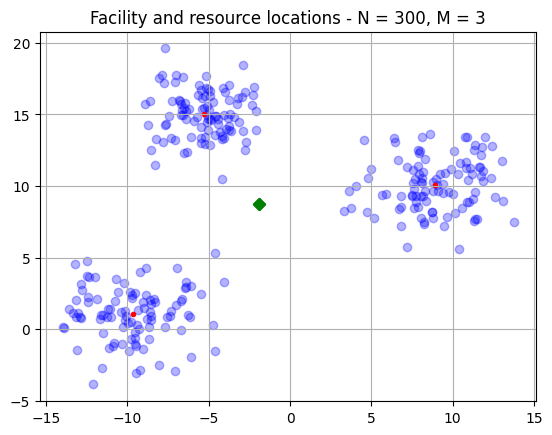

In [48]:
flp.plot_flp(res_means, Y1)

In [31]:
beta0 = 1e-3
betaf = 1e1
beta_grow = 2
F_array, b_array, P_array, Y_array = flp.anneal(x0, beta0, betaf, beta_grow, p, gamma, alpha_h, alpha_l, T_f=4, dt_init=0.01, dt_min=1e-5, dt_max=0.5, Ftol=1e-3, xtol=1e-3, allowPrint=True)

xtol successful	iter:7	time 5.181e-02	xtol=3.981e-03 < xtol=1.000e-02
beta:2.000e-03	F:1.830e+02
xtol successful	iter:17	time 1.920e-02	xtol=9.991e-03 < xtol=1.000e-02
beta:4.000e-03	F:2.008e+02
xtol successful	iter:32	time 1.869e-02	xtol=9.933e-03 < xtol=1.000e-02
beta:8.000e-03	F:1.815e+02
Ftol successful	iter:255	time 1.143e-01	Ftol=9.994e-03 < Ftol=1.000e-02
beta:1.600e-02	F:1.576e+02
Ftol successful	iter:54	time 9.864e-02	Ftol=4.838e-03 < Ftol=1.000e-02
beta:3.200e-02	F:1.077e+02
xtol successful	iter:13	time 5.254e-02	xtol=9.052e-03 < xtol=1.000e-02
beta:6.400e-02	F:6.609e+01
xtol successful	iter:137	time 3.492e-01	xtol=6.103e-03 < xtol=1.000e-02
beta:1.280e-01	F:3.587e+01
xtol successful	iter:46	time 3.866e-01	xtol=5.769e-03 < xtol=1.000e-02
beta:2.560e-01	F:2.041e+01
xtol successful	iter:21	time 4.329e-01	xtol=6.790e-03 < xtol=1.000e-02
beta:5.120e-01	F:1.168e+01
xtol successful	iter:10	time 2.606e-01	xtol=2.711e-03 < xtol=1.000e-02
beta:1.024e+00	F:7.192e+00
xtol successful	ite

In [32]:
Y_array[-1]

array([[  4.76161295,   1.10366047],
       [ -7.95703637,  -9.2656444 ],
       [-14.5406602 ,   0.51569689],
       [-12.6563101 ,  11.14989055],
       [ -3.37639078,  -7.11763034],
       [ 14.05639033, -16.87193871],
       [  2.04458666,  -2.56351649],
       [-11.92156014,   4.71737017],
       [ 14.30968528,  -0.10033049],
       [ -2.49988549, -18.88205035]])

In [33]:
P_array[-1]

array([[9.99926034e-08, 2.77351095e-04, 9.99926034e-08, ...,
        9.99926034e-08, 9.99926034e-08, 9.99721849e-01],
       [9.99938722e-08, 9.99938722e-08, 9.99938722e-08, ...,
        9.99938722e-08, 9.99938722e-08, 9.99761688e-01],
       [9.99923471e-08, 2.88900977e-04, 9.99923471e-08, ...,
        9.99923471e-08, 9.99923471e-08, 9.99710299e-01],
       ...,
       [1.12106060e-06, 9.99930772e-08, 9.99930772e-08, ...,
        9.99930772e-08, 9.99930772e-08, 1.93239059e-04],
       [2.37774830e-06, 9.99929055e-08, 9.99929055e-08, ...,
        9.99929055e-08, 9.99929055e-08, 1.92982792e-04],
       [4.82179846e-06, 9.99934358e-08, 9.99934358e-08, ...,
        9.99934358e-08, 9.99934358e-08, 1.71264506e-04]])

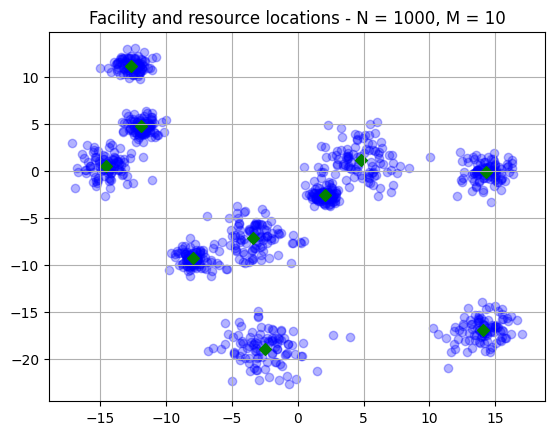

In [34]:
flp.plot_flp(res_means, Y_array[-1])

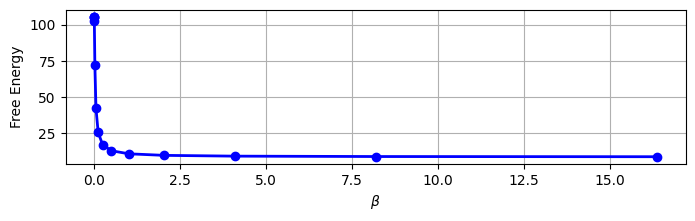

In [52]:
plt.figure(figsize=(8,2))
plt.plot(b_array, F_array, marker='o', color='b', linewidth = 2)
plt.xlabel(rf'$\beta$')
plt.ylabel(rf'Free Energy')
plt.grid()
plt.show()